In [13]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class Convolution:
    #include init? idk
    # num_img_in: Number of inputs
    # filter_size: Size of kernel, will be square & less than 28
    # num_filters: Number of filters to run input against
    def __init__(self, num_img_in, filter_size, num_filters, step_size):
        self.num_img_in = num_img_in
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.step_size = step_size
        
    def forward_prop(self, img_in, features):
        N = len(img_in)
        M = len(img_in[0])
        step_size = self.step_size
        # if step size doesn't match up -> padding()
        # gives us amount of padding needed\n",
        pad_N = (N - len(features)) % step_size
        pad_M = (M - len(features[0])) % step_size
        img_in = self.padding(img_in, N+pad_N, M+pad_M) #padded img
        print(img_in)
        # should be whole numbers\n",
        P = (len(img_in) - len(features)) / step_size + 1
        Q = (len(img_in[0]) - len(features)) / step_size + 1

        # find good ways to add padding, possibly this part is not needed?
        if P.is_integer() is False:
            return "Bad Dimension P"
        if Q.is_integer() is False:
            return "Bad dimension Q"
        else:
            P = int(P)
            Q = int(Q)

        print(P, Q)
        out = np.zeros((self.num_filters, P, Q)) # PxQ output array\n",

        # iterate thru the input and output to corresponding part in out
        # output f amount of filters from each layer
        for f in range(0, self.num_filters):
            for i in range(0, P):
                for j in range (0, Q):
                    # Take dot product of the flattened filter and part it is covering\n",
                    out[f, i, j] = np.dot(np.ndarray.flatten(img_in[i:i+len(features[f]),
                        j:j+len(features[f][0])]), np.ndarray.flatten(features[f]))
        return out
        
    # Given set of filters (features) #odd x #odd, iterate over input and multiply
    # img_in: a square NxM #even x #even matrix representing one of the RGB values of the input
    # features: filters/features that we compare the input against
    # step_size: fixed to 1 (does not have any effect)
    # returns a NxM matrix where each value is the result of multiplying
    # filter with the input, then dividing by the size of the filter
    # pad
    # Need to add filters to feature map
    def forward_prop_A(self, img_in, features, pad):
        N = len(img_in)
        M = len(img_in[0])
        
        # padded img as specified
        img_in = self.padding(img_in, N + 2 * pad, M + 2 * pad)

        # stride here is 1
        # out_N = (N - features_size + 2*pad_N) / stride + 1
        # out_M = (M - features_size + 2*pad_M) / stride + 1
        stride = 1
        # NxM output array (square)
        # assume the number is divisible by the stride
        out = np.zeros((len(features)
                        , (N - len(features[0]) + 2 * pad) // stride + 1
                        , (M - len(features[0][0]) + 2 * pad) // stride + 1 ))
        
        # iterate thru the input and output to corresponding part in out
        for f in range(0, self.num_filters):
            for i in range(0, len(out[0])):
                for j in range (0, len(out[0][0])):
                    # Take dot product of the flattened filter and part of input it is covering
                    out[f, i, j] = np.dot(np.ndarray.flatten(img_in[i:i+len(features[f]),
                                    j:j+len(features[f][0])]), np.ndarray.flatten(features[f]))
        return out
    
    # assume stride = 1 (not tested for stride > 1)
    # loss = loss gradient from the next layer (feeding back to previous layer)
    # filter_weight = previous/original kernel/filter
    # learning_rate = alpha or how much change we want (the same across the network)
    # pad = pad_size must be the same as forward_prop's pad size for this layer.
    # loss_size = img_size
    def back_prop(self, img_in, loss, filter_weight, learning_rate, pad):
        dL_dF = np.zeros(np.shape(filter_weight))
        X = img_in
        N = len(X)
        M = len(X[0])

        # padded img
        X = self.padding(X, N + 2*pad, M + 2*pad)
        
        # update filter
        # X is the image @ this stage
        # chain rule: dL_dF = dL_dO * dO_dF
        # but dL_dO is the input loss
        # and dO_dF results in the image X
        # dL_dF = convolution 2d between X (image @ this stage) and loss   
        # ex. dL_dF 3x3 =  Conv image 4x4 (padded to 6x6), loss 4x4
        for i in range(0, N - 1):
            for j in range (0, M - 1):
                dL_dF[i, j] = np.dot(np.ndarray.flatten(X[i:i+len(loss),
                            j:j+len(loss[0])]), np.ndarray.flatten(loss))
        
        # update the image X
        # need to rotate the filter 180deg and pad it
        # convolution from right to left and bottom to top
        # F33 F32 F31
        # F23 F22 F21
        # F13 F12 F11
        dL_dX = np.zeros(np.shape(img_in))
        # rotate the filter 180deg
        rot_filter_weight = np.rot90(filter_weight, 2)
        # pad the filter 
        loss = self.padding(loss, N + 2*pad, M + 2*pad)
        # dL_dX = convolution 2d between rot180(Filter) and loss 
        # convolution from right to left and bottom to top
        for i in range(N - 1, -1, -1):
            for j in range (M - 1, -1, -1):
                dL_dX[i, j] = np.dot(np.ndarray.flatten(loss[i:i+len(rot_filter_weight),
                            j:j+len(rot_filter_weight[0])]), np.ndarray.flatten(rot_filter_weight))
                
        # F = F - a * dL/dF
        filter_weight = filter_weight - learning_rate * dL_dF
        print(filter_weight)
        return filter_weight, X
    
    # Add 0s to the border of orig_img as needed to achieve NxM matrix
    # assume orig_img is a square matrix with #odd x #odd
    def padding(self, orig_img, N, M):
        #print("print" ,np.shape(orig_img))
        if N - np.shape(orig_img)[0] < 0 or M - np.shape(orig_img)[1] < 0:
            raise "target NxM must be larger or equal to orig_img"
        starting_row = (N - np.shape(orig_img)[0]) // 2
        starting_column = (M - np.shape(orig_img)[1]) // 2
        pad_arr = np.zeros((N, M))
        pad_arr[starting_row:starting_row+np.shape(orig_img)[0], starting_column:starting_column+np.shape(orig_img)[1]] = orig_img
        return pad_arr

# Main Activity
## Question 1

In [21]:
data = []
with open('./img.csv') as img_file:
    csv_read = csv.reader(img_file)
    for row in csv_read:
        data.append(list(map(int, row)))

        
# plt.imshow(data, cmap='gray')
# plt.show()

## Question 2

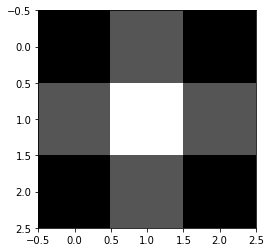

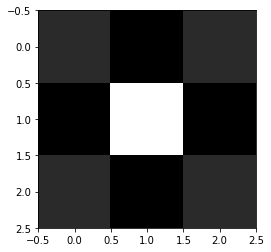

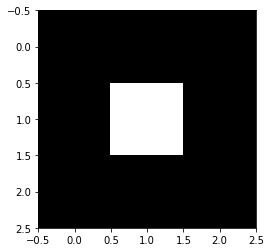

Dimension:  (3, 3)


In [23]:
kernels = []
# fun fact, this is Gaussian blur
kernel1 = 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]])
kernels.append(kernel1)
plt.imshow(kernel1, cmap='gray')
plt.show()
# sharpen
kernel2 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernels.append(kernel2)
plt.imshow(kernel2, cmap='gray')
plt.show()
# edge detection
kernel3 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
kernels.append(kernel3)
plt.imshow(kernel3, cmap='gray')
plt.show()

# print("Number of features: ", len(kernels))
# print("Dimension: ", np.shape(kernel1))

## Question 3 & 4

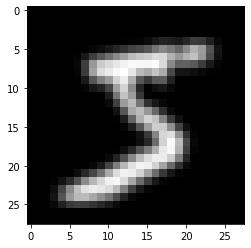

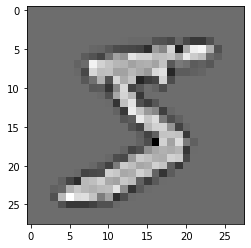

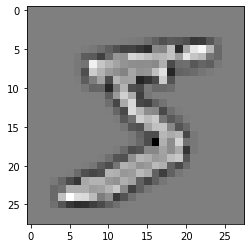

In [25]:
num_img_in = 1
filter_size = len(kernels[0])
num_filters = len(kernels)
step_size = 1

conv = Convolution(num_img_in, filter_size, num_filters, step_size)
# here we maintain the size of the feature maps
padding = (filter_size - 1) // 2
# perform kernel convolution
feature_maps = conv.forward_prop_A(data, kernels, padding)
# display the results
for fm in feature_maps:
    plt.imshow(fm, cmap='gray')
    plt.show()

## Question 5

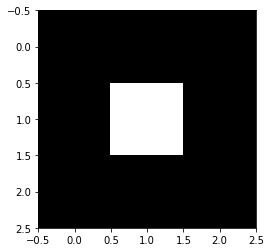

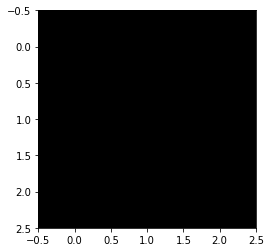

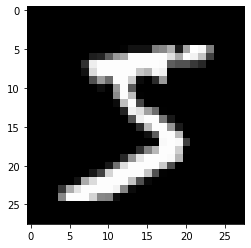

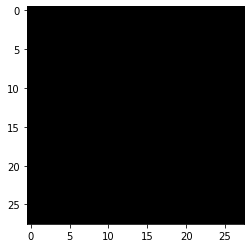

In [27]:
new_kernels = []
kernel4 = np.array([[0,0,0],[0,1,0],[0,0,0]])
new_kernels.append(kernel4)
plt.imshow(kernel4, cmap='gray')
plt.show()

kernel5 = np.zeros((3,3))
new_kernels.append(kernel5)
plt.imshow(kernel5, cmap='gray')
plt.show()

num_img_in = 1
filter_size = len(new_kernels[0])
num_filters = len(new_kernels)
step_size = 1

new_conv = Convolution(num_img_in, filter_size, num_filters, step_size)
# here we maintain the size of the feature maps
new_padding = (filter_size - 1) // 2
# perform kernel convolution
new_feature_maps = new_conv.forward_prop_A(data, new_kernels, new_padding)
# display the results
for fm in new_feature_maps:
    plt.imshow(fm, cmap='gray')
    plt.show()